# Method 1 Shadow removal CIELAB

In [1]:
import cv2
import gc
import numpy as np
import pandas as pd
import rasterio
from skimage.color import lab2lch, rgb2lab
from skimage.exposure import rescale_intensity
from skimage.morphology import disk
from sklearn.cluster import KMeans

In [2]:
image_file='D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg'

In [3]:
shadow_mask_file='D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histnewshadowMask1.jpg'

In [4]:
lch_image_file='D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/LAB2CIELch.jpg'

In [5]:
convolve_window_size = 7

In [6]:
num_thresholds = 3
struc_elem_size = 5

In [7]:
if(convolve_window_size % 2 == 0):
  raise ValueError('Please make sure that convolve-window_size is an odd integer')

buffer= int((convolve_window_size - 1) / 2)


with rasterio.open(image_file) as f:
    metadata = f.profile
    img = rescale_intensity(np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0]), out_range = 'uint8')
    img = img[:, :, 0 : 3]

c:\users\dolonchapa\appdata\local\programs\python\python310\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [8]:
lch_img = np.float32(lab2lch(rgb2lab(img)))

In [9]:
with rasterio.open(lch_image_file, 'w', **metadata) as dst:
    dst.write(np.transpose(lch_img, [2, 0, 1]))

c:\users\dolonchapa\appdata\local\programs\python\python310\lib\site-packages\rasterio\__init__.py:331: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [10]:
l_norm = rescale_intensity(lch_img[:, :, 0], out_range = (0, 1))
h_norm = rescale_intensity(lch_img[:, :, 2], out_range = (0, 1))
sr_img = (h_norm + 1) / (l_norm + 1)
log_sr_img = np.log(sr_img + 1)
    
del l_norm, h_norm, sr_img
gc.collect()

0

In [11]:
avg_kernel = np.ones((convolve_window_size, convolve_window_size)) / (convolve_window_size ** 2)
blurred_sr_img = cv2.filter2D(log_sr_img, ddepth = -1, kernel = avg_kernel)

In [12]:
del log_sr_img
gc.collect()

0

In [13]:
flattened_sr_img = blurred_sr_img.flatten().reshape((-1, 1))
labels = KMeans(n_clusters = num_thresholds + 1, max_iter = 10000).fit(flattened_sr_img).labels_
flattened_sr_img = flattened_sr_img.flatten()
df = pd.DataFrame({'sample_pixels': flattened_sr_img, 'cluster': labels})
threshold_value = df.groupby(['cluster']).min().max()[0]
df['Segmented'] = np.uint8(df['sample_pixels'] >= threshold_value)

c:\users\dolonchapa\appdata\local\programs\python\python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
del blurred_sr_img, flattened_sr_img, labels, threshold_value
gc.collect()

0

In [15]:
shadow_mask_initial = np.array(df['Segmented']).reshape((img.shape[0], img.shape[1]))
struc_elem = disk(struc_elem_size)
shadow_mask = np.expand_dims(np.uint8(cv2.morphologyEx(shadow_mask_initial, cv2.MORPH_CLOSE, struc_elem)), axis = 0)

In [16]:
del df, shadow_mask_initial, struc_elem
gc.collect()

0

In [17]:
metadata['count'] = 1
with rasterio.open(shadow_mask_file, 'w', **metadata) as dst:
    dst.write(shadow_mask)

c:\users\dolonchapa\appdata\local\programs\python\python310\lib\site-packages\rasterio\__init__.py:331: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [18]:
corrected_image_file= 'D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/corrected_img.jpg'

In [19]:
exponent = 1

In [20]:
with rasterio.open(image_file) as f:
    metadata = f.profile
    img = rescale_intensity(np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0]), out_range = 'uint8')

c:\users\dolonchapa\appdata\local\programs\python\python310\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [21]:
with rasterio.open(shadow_mask_file) as s:
    shadow_mask = s.read(1)

In [22]:
corrected_img = np.zeros((img.shape), dtype = np.uint8)
non_shadow_mask = np.uint8(shadow_mask == 0)

In [23]:
for i in range(img.shape[2]):
    shadow_area_mask = shadow_mask * img[:, :, i]
    non_shadow_area_mask = non_shadow_mask * img[:, :, i]
    shadow_stats = np.float32(np.mean(((shadow_area_mask ** exponent) / np.sum(shadow_mask))) ** (1 / exponent))
    non_shadow_stats = np.float32(np.mean(((non_shadow_area_mask ** exponent) / np.sum(non_shadow_mask))) ** (1 / exponent))
    mul_ratio = ((non_shadow_stats - shadow_stats) / shadow_stats) + 1
    corrected_img[:, :, i] = np.uint8(non_shadow_area_mask + np.clip(shadow_area_mask * mul_ratio, 0, 255))

In [24]:
with rasterio.open(corrected_image_file, 'w', **metadata) as dst:
    dst.write(np.transpose(corrected_img, [2, 0, 1]))
    #dst.write(corrected_img,[1,0,2])

# Method 2 YCbCr

In [25]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [26]:
or_img = cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg')

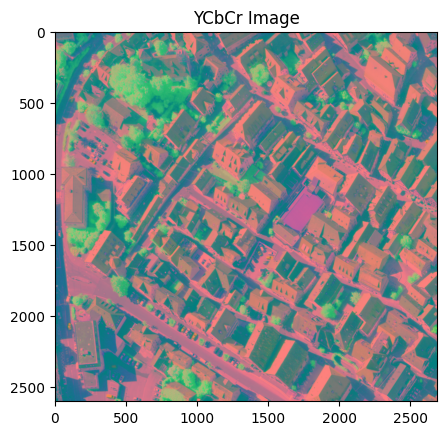

In [27]:
# covert the BGR image to an YCbCr image
y_cb_cr_img = cv2.cvtColor(or_img, cv2.COLOR_BGR2YCrCb)

plt.subplot(1, 1, 1)
plt.title('YCbCr Image')
plt.imshow(y_cb_cr_img)

plt.imsave("D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/YCbCrImage.jpg", np.array(y_cb_cr_img))
#cv2.imshow("YCBCR", y_cb_cr_img)

In [28]:
# copy the image to create a binary mask later
binary_mask = np.copy(y_cb_cr_img)

In [29]:
# get mean(AVG.) value of the pixels in Y plane (sum / count)
y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

In [30]:
# get standard deviation of channel in Y plane
y_std = np.std(cv2.split(y_cb_cr_img)[0])

In [31]:
# classify pixels as shadow and non-shadow pixels
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):

        if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
            # paint it white (shadow)
            binary_mask[i, j] = [255, 255, 255]
        else:
            # paint it black (non-shadow)
            binary_mask[i, j] = [0, 0, 0]

In [32]:
# Using morphological operation
# The misclassified pixels are
# removed using dilation followed by erosion. (Closing)
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(binary_mask, kernel, iterations=1)

In [33]:
# sum of pixel intensities in the lit areas
spi_la = 0

In [34]:
# sum of pixel intensities in the shadow
spi_s = 0

In [35]:
# number of pixels in the lit areas
n_la = 0

In [36]:
# number of pixels in the shadow
n_s = 0

In [37]:
# get sum of pixel intensities in the lit areas
# and sum of pixel intensities in the shadow
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
            spi_la = spi_la + y_cb_cr_img[i, j, 0]
            n_la += 1
        else:
            spi_s = spi_s + y_cb_cr_img[i, j, 0]
            n_s += 1

In [38]:
# get the average pixel intensities in the lit areas
average_ld = spi_la / n_la

In [39]:
# get the average pixel intensities in the shadow
average_le = spi_s / n_s

In [40]:
# difference of the pixel intensities in the shadow and lit areas
i_diff = average_ld - average_le

In [41]:
# get the ratio between average shadow pixels and average lit pixels
ratio_as_al = average_ld / average_le

In [43]:
# color adjustment
# added these difference
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:

            y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,
                                 y_cb_cr_img[i, j, 2] + ratio_as_al]

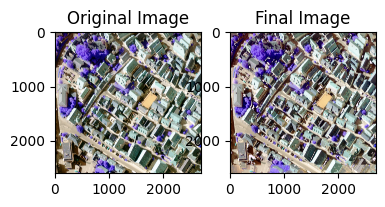

In [44]:
# convert the YCbCr image to the BGR image
final_image = cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)

plt.subplot(2, 3, 4)
plt.title('Original Image')
plt.imshow(or_img)

plt.imsave("D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/OriginalImage.jpg", np.array(or_img))


plt.subplot(2, 3, 5)
plt.title('Final Image')
plt.imshow(final_image)

plt.imsave("D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/FinalImage.jpg", np.array(final_image))

#cv2.imshow("before", or_img)
#cv2.imshow("after", final_image)

### Method 3 HSI 

In [ ]:
## Shadow Detection

import numpy as np
import cv2
import math

img = cv2.imread('shadow.jpg')
gray = cv2.imread('shadow.jpg', 0)
blur = cv2.bilateralFilter(img,9,75,75)

#############################    HSI CONVERSION    ###########################

blur = np.divide(blur, 255.0)

hsi = np.zeros((blur.shape[0],blur.shape[1],blur.shape[2]),dtype=np.float)
ratio_map = np.zeros((blur.shape[0],blur.shape[1]),dtype=np.uint8)

for i in range(blur.shape[0]):
    for j in range(blur.shape[1]):
        hsi[i][j][2] = (blur[i][j][0]+blur[i][j][1]+blur[i][j][2])/3
        hsi[i][j][0] = math.acos(((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][0]))/(2*math.sqrt((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][1])+(blur[i][j][2]-blur[i][j][0])*(blur[i][j][1]-blur[i][j][0]))))
        hsi[i][j][1] = 1 - 3*min(blur[i][j][0],blur[i][j][1],blur[i][j][2])/hsi[i][j][2]
        ratio_map[i][j] = hsi[i][j][0]/(hsi[i][j][2]+0.01)                    

###############################################################################
 
#########################    OTSU'S METHOD    #################################

hist = np.histogram(ratio_map.ravel(),256,[0,256])
ret,th = cv2.threshold(ratio_map,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
median = cv2.medianBlur(th,15)
###############################################################################

cv2.imshow("original_image",img)
cv2.imshow("detected_shadow",median)

cv2.waitKey(0)
cv2.destroyAllWindows(0)

In [45]:
# Shadow Removal

import cv2
import numpy as np
import math

In [46]:
img = cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg')
gray = cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg', 0)
blur = cv2.bilateralFilter(img,9,75,75)

In [47]:
#############################    HSI CONVERSION    ###########################

blur = np.divide(blur, 255.0)

hsi = np.zeros((blur.shape[0],blur.shape[1],blur.shape[2]),dtype=np.float)
ratio_map = np.zeros((blur.shape[0],blur.shape[1]),dtype=np.uint8)

for i in range(blur.shape[0]):
    for j in range(blur.shape[1]):
        hsi[i][j][2] = (blur[i][j][0]+blur[i][j][1]+blur[i][j][2])/3
        hsi[i][j][0] = math.acos(((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][0]))/(2*math.sqrt((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][1])+(blur[i][j][2]-blur[i][j][0])*(blur[i][j][1]-blur[i][j][0]))))
        hsi[i][j][1] = 1 - 3*min(blur[i][j][0],blur[i][j][1],blur[i][j][2])/hsi[i][j][2]
        ratio_map[i][j] = hsi[i][j][0]/(hsi[i][j][2]+0.01)                    

###############################################################################

C:\Users\DOLONCHAPA\AppData\Local\Temp\ipykernel_26456\2342344962.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hsi = np.zeros((blur.shape[0],blur.shape[1],blur.shape[2]),dtype=np.float)
C:\Users\DOLONCHAPA\AppData\Local\Temp\ipykernel_26456\2342344962.py:11: RuntimeWarning: invalid value encountered in double_scalars
  hsi[i][j][0] = math.acos(((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][0]))/(2*math.sqrt((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][1])+(blur[i][j][2]-blur[i][j][0])*(blur[i][j][1]-blur[i][j][0]))))
C:\Users\DOLONCHAPA\AppData\Local\Temp\ipykernel_26456\2342344962.py:12: RuntimeWarning: invalid value encountered in d